In [1]:
import os, io, shutil
import time
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch import topk
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.detectiondataset import VideoDataset

import sys
sys.path.append('./src/pytorch-lr-finder')
sys.path.append('./src/kinetics_i3d_pytorch/src')
from lr_finder import LRFinder

import json
import pandas as pd

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
model_name = 'i3d'
img_size = 224
crop_size = img_size
batch_size = 4
clip_len = 16
num_classes = 1

transform = transforms.Compose([
        transforms.Resize((crop_size, crop_size)), # bilinear
        transforms.ToTensor(), #ndarray => torch.FloatTensor [0.0, 1.0].
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1.0, 1.0]
    ])

data_name = 'anesthesia'
dataset_path = os.getcwd()
dataset = {
    'train':VideoDataset(dataset_path, clip_len=clip_len, split='train', transform=transform, use_keypoints=True),
    'val':VideoDataset(dataset_path, clip_len=clip_len, split='val', transform=transform, use_keypoints=True),
    'test':VideoDataset(dataset_path, clip_len=clip_len, split='test', transform=transform)
}

#train: clean: 279 notclean: 244
#val:   clean:  25 notclean:  31
#test:  clean:  27 notclean:  28

Number of /data/private/minjee-video/handhygiene/images/train people: 134
Number of /data/private/minjee-video/handhygiene/images/val people: 12
Number of /data/private/minjee-video/handhygiene/images/test people: 16


In [3]:
#for phase in ['train', 'val', 'test']:
#    for i in tqdm(range(dataset[phase].__len__())):
#        rgb, flow, label = dataset[phase].__getitem__(i)
        #print(rgb.shape, flow.shape, label.shape)

# Generate partial-clips 

In [3]:
import os
from tqdm import tqdm
from dataloader.augmentation import AugmentDataset
dataset_path = os.getcwd()

#for phase in ['train', 'val', 'test']:
#    dataset = AugmentDataset(dataset_path, split=phase)
#    for i, data in enumerate(tqdm(range(dataset.__len__()))):
#        dataset.__generate_temporal_augmentation__(i)

# Visualization of Dataset

100%|██████████| 17/17 [00:00<00:00, 9541.44it/s]


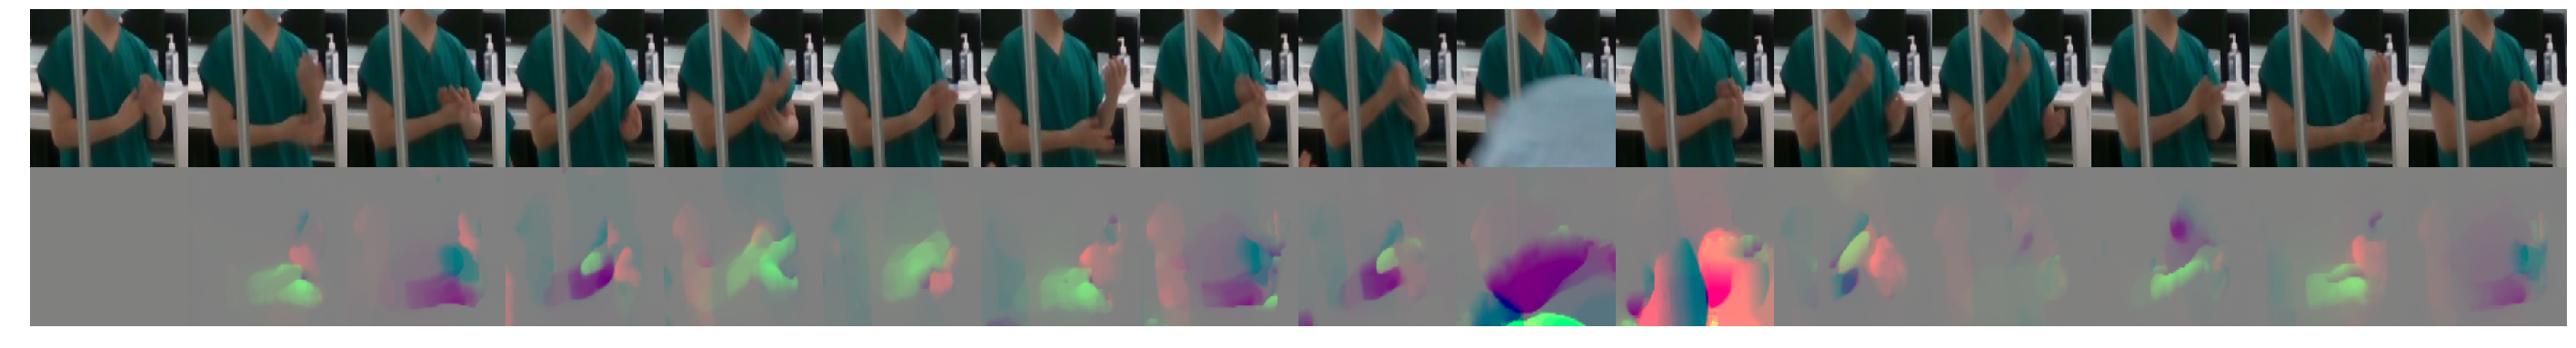

tensor([1])


In [9]:
import matplotlib.pyplot as plt


def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    global rgb
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    global flow
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(item[2])
show_dataset(dataset['train'].__getitem__(53))
#print(dataset['train'].__getpath__(48))

In [18]:
import imageio
def generate_gif_from_npy(item, path):
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    shape = np.asarray(flows[0]).shape
    images = []
    optflows = []
    
    for rgb in rgbs:
        images.append((np.asarray(rgb).transpose(1, 2, 0)+1)/2)
        
    tmp = np.zeros((shape[1], shape[2], 1))
    for flow in flows:
        optflows.append((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2)
        
    print(path)
    basename = os.path.basename(path)
    imgdst = '{}_rgb.gif'.format(basename)
    flowdst = '{}_flow.gif'.format(basename)
    imageio.mimsave(os.path.join(path, imgdst), images)
    imageio.mimsave(os.path.join(path, flowdst), optflows)

In [31]:
item = dataset['train'].__getitem__(40)
path = dataset['train'].__getpath__(40)
#print(path)
#generate_gif_from_npy(item, path)

100%|██████████| 23/23 [00:00<00:00, 2007.60it/s]


In [32]:
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=16),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, num_workers=16),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=16)
}

# Train 

In [33]:
from i3dpt import I3D, Unit3Dpy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import copy

model_name = 'i3d'
logpath = os.path.join('./logs/', model_name)
if not os.path.exists(logpath): os.mkdir(logpath)
writer = SummaryWriter(logpath)


i3d_model_path = './src/kinetics_i3d_pytorch/'
sys.path.append(i3d_model_path)
rgb_weights_path = i3d_model_path+'model/model_rgb.pth'
flow_weights_path = i3d_model_path+'model/model_flow.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
def modify_last_layer(out_channels):
    return Unit3Dpy(in_channels=1024, out_channels=out_channels, kernel_size=(1, 1, 1),
            activation=None, use_bias=True, use_bn=False)

In [35]:
i3d_rgb = I3D(num_classes=400, modality='rgb')
i3d_rgb.load_state_dict(torch.load(rgb_weights_path))
i3d_rgb.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
i3d_rgb.softmax = torch.nn.Sigmoid()

i3d_flow = I3D(num_classes=400, modality='flow')
i3d_flow.load_state_dict(torch.load(flow_weights_path))
i3d_flow.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
i3d_flow.softmax = torch.nn.Sigmoid()
i3d_flow.to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    i3d_rgb = nn.DataParallel(i3d_rgb)
    i3d_flow = nn.DataParallel(i3d_flow)
i3d_rgb.to(device)
i3d_flow.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): I3D(
    (conv3d_1a_7x7): Unit3Dpy(
      (pad): ConstantPad3d(padding=(2, 3, 2, 3, 2, 3), value=0)
      (conv3d): Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
      (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxPool3d_2a_3x3): MaxPool3dTFPadding(
      (pad): ConstantPad3d(padding=(0, 1, 0, 1, 0, 0), value=0)
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=True)
    )
    (conv3d_2b_1x1): Unit3Dpy(
      (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3d_2c_3x3): Unit3Dpy(
      (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (batch3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxPool3

In [36]:
#criterion = F.cross_entropy
criterion = F.binary_cross_entropy
#def optimizer(model):
#    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-7)
#    lr_finder = LRFinder(model, optimizer, criterion, modality='rgb', device="cuda")
#    lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=1000, step_mode="exp")
#    lr_finder.plot()

def optimizer(model):
    return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-7)
#optimizer(i3d_rgb)
#optimizer(i3d_flow)

In [37]:
# train by epoch
def train(dataloders, optimizer, num_epochs=50): # 
    since = time.time()
    best_model_wts = {'rgb':i3d_rgb.state_dict(), 'flow':i3d_flow.state_dict()}
    best_acc = 0.0
    iterations = {'train': 0, 'val': 0}
    
    for epoch in tqdm(range(num_epochs)):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                i3d_rgb.train()
            else:
                i3d_rgb.eval()

            running_loss = 0.0
            running_corrects = {'rgb':0, 'flow':0, 'joint':0}
            
            for i, (samples) in enumerate(dataloders[phase]):
                iterations[phase] += 1
                rgbs = samples[0] #BCDHW
                flows = samples[1]
                targets = samples[2]
                
                #print(rgbs.shape, flows.shape, targets.shape)
                ##### rgb model
                optimizer(i3d_rgb).zero_grad()
                rgbs = Variable(rgbs.to(device))
                targets = Variable(targets.to(device)).float()
                
                rgb_out_vars, rgb_out_logits = i3d_rgb(rgbs)
                rgb_preds = torch.round(rgb_out_vars.data)
                #_, rgb_preds = torch.max(rgb_out_vars.data, 1)
                
                #print(rgb_out_vars.shape, rgb_preds.shape)
                ##### flow model
                optimizer(i3d_flow).zero_grad()
                flows = Variable(flows.to(device))
                
                flow_out_vars, flow_out_logits = i3d_flow(flows)
                flow_preds = torch.round(flow_out_vars.data)
                #_, flow_preds = torch.max(flow_out_vars.data, 1)
                
                #print(flow_out_vars.shape, flow_preds.shape)
                ##### joint model
                out_logit = rgb_out_logits + flow_out_logits
                # for softmax model
                #out_softmax = torch.nn.functional.softmax(out_logit, 1)
                #_, out_preds = torch.max(out_softmax, 1)
                #out_loss = criterion(out_softmax, targets.view(-1)).to(device)
                
                # for sigmoid
                out_sigmoid = torch.sigmoid(out_logit)
                print("out_sigmoid:{}".format(out_sigmoid.data))
                out_preds = torch.round(out_sigmoid.data)
                out_loss= criterion(out_sigmoid, targets).to(device)
                
                running_loss += out_loss.item() * rgbs.size(0)
                running_corrects['rgb'] += torch.sum(rgb_preds.to(device) == targets.to(device)) 
                running_corrects['flow'] += torch.sum(flow_preds.to(device) == targets.to(device)) 
                running_corrects['joint'] += torch.sum(out_preds.to(device) == targets.to(device)) 

                del rgbs, flows, out_loss, out_sigmoid#, out_softmax #
                torch.cuda.empty_cache()
            
            ## for plotting 
            # per epoch
            if phase == 'train':
                train_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                train_epoch_rgb_acc = running_corrects['rgb'].double()  / len(dataloaders[phase].dataset)
                train_epoch_flow_acc = running_corrects['flow'].double()  / len(dataloaders[phase].dataset)
                train_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
                    
            else:
                valid_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                valid_epoch_rgb_acc = running_corrects['rgb'].double() / len(dataloaders[phase].dataset)
                valid_epoch_flow_acc = running_corrects['flow'].double() / len(dataloaders[phase].dataset)
                valid_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
            
            # deep copy best model
            if phase == 'val' and valid_epoch_joint_acc > best_acc:
                best_acc = valid_epoch_joint_acc
                best_model_rgb_wts = copy.deepcopy(i3d_rgb.state_dict())
                best_model_flow_wts = copy.deepcopy(i3d_flow.state_dict())
                best_iters = iterations['train']
                
        writer.add_scalars('Loss', {'training': train_epoch_loss, 
                                    'validation': valid_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'training_rgb': train_epoch_rgb_acc, 
                                        'training_flow': train_epoch_flow_acc,
                                        'training_joint': train_epoch_joint_acc,
                                        'validation_rgb': valid_epoch_rgb_acc,
                                        'validation_flow': valid_epoch_flow_acc,
                                        'validation_joint': valid_epoch_joint_acc}, epoch)
        
        torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_rgb', epoch)))
        torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_flow', epoch)))
    
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        train_epoch_loss, train_epoch_joint_acc, 
                        valid_epoch_loss, valid_epoch_joint_acc))
        
    print('Best val Acc: {:4f}'.format(best_acc))

    i3d_rgb.load_state_dict(best_model_rgb_wts)
    i3d_flow.load_state_dict(best_model_flow_wts)
    torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_rgb', best_iters)))
    torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_flow', best_iters)))
    writer.close()
    return i3d_rgb, i3d_flow

In [38]:
train(dataloaders, optimizer, num_epochs=50)

100%|██████████| 14/14 [00:00<00:00, 12579.32it/s]


out_sigmoid:tensor([[0.4664],
        [0.4629],
        [0.4681],
        [0.4683]], device='cuda:0')
out_sigmoid:tensor([[0.4692],
        [0.4755],
        [0.4832],
        [0.4740]], device='cuda:0')
out_sigmoid:tensor([[0.4714],
        [0.4785],
        [0.4700],
        [0.4805]], device='cuda:0')
out_sigmoid:tensor([[0.4749],
        [0.4799],
        [0.4758],
        [0.4846]], device='cuda:0')
out_sigmoid:tensor([[0.4519],
        [0.4625],
        [0.4549],
        [0.4663]], device='cuda:0')
out_sigmoid:tensor([[0.4628],
        [0.4571],
        [0.4592],
        [0.4798]], device='cuda:0')
out_sigmoid:tensor([[0.4760],
        [0.4654],
        [0.4634],
        [0.4709]], device='cuda:0')
out_sigmoid:tensor([[0.4758],
        [0.4759],
        [0.4673],
        [0.4728]], device='cuda:0')


KeyboardInterrupt: 

In [10]:
flow = np.load('./images/train/clean/13_20181129_frames000808/13_20181129_frames000808.npy')

In [7]:
from glob import glob
weights_rgb = glob('./weights/handhygiene_i3d_rgb_epoch_*.pth')
weights_flow = glob('./weights/handhygiene_i3d_flow_epoch_*.pth')

In [14]:
from PIL import Image
buffer = []
for i, flw in enumerate(flow):
    shape = flw.shape
    # to make extra 3 channel to use torchvision transform
    tmp = np.empty((shape[0], shape[1], 1)).astype(np.uint8) 
    img = np.dstack((flw.astype(np.uint8), tmp))
    img = Image.fromarray(img)
    buffer.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

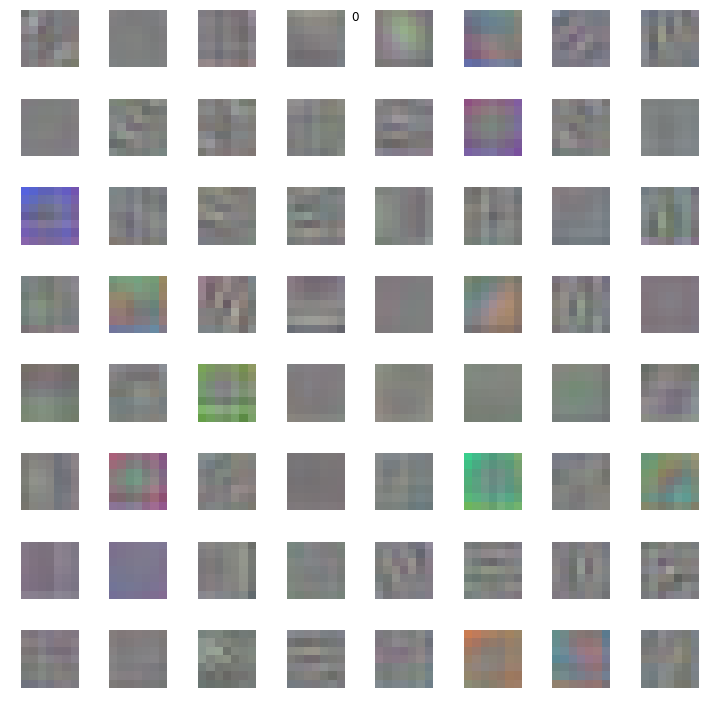

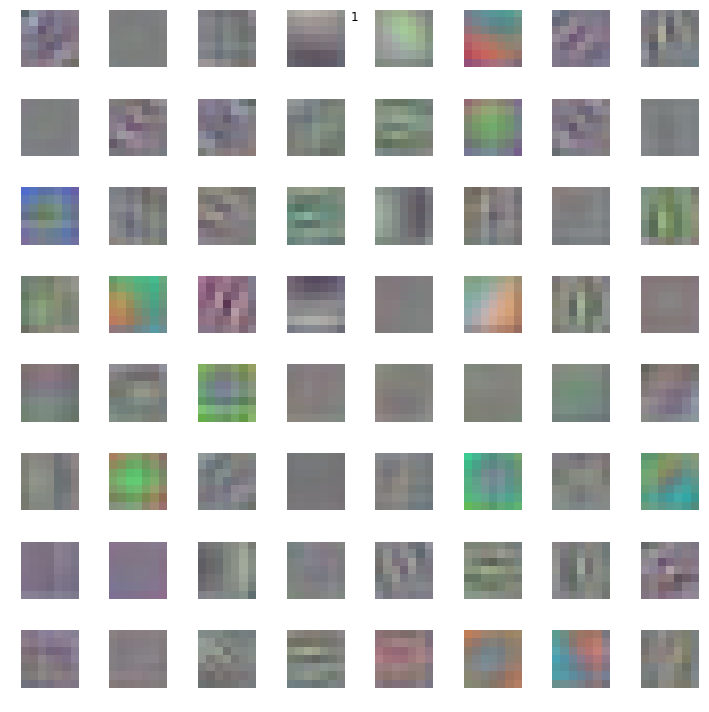

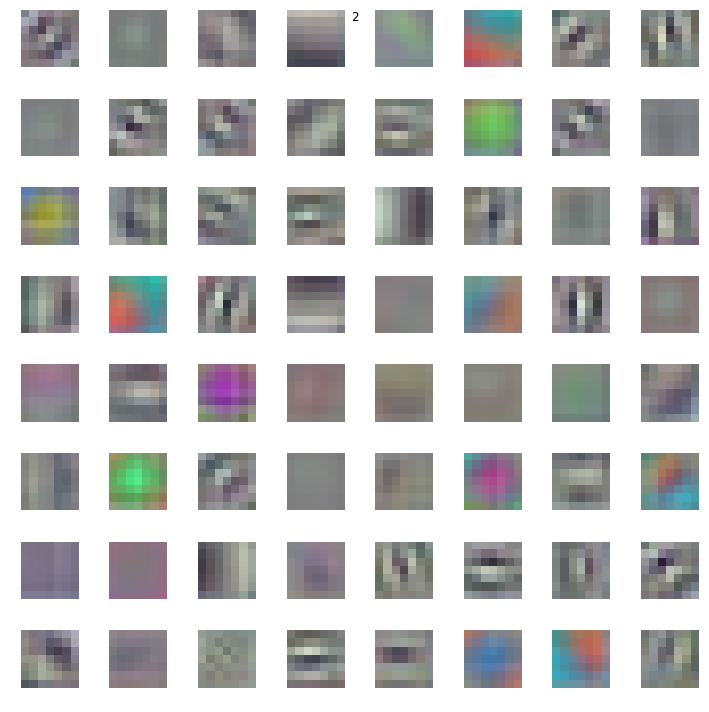

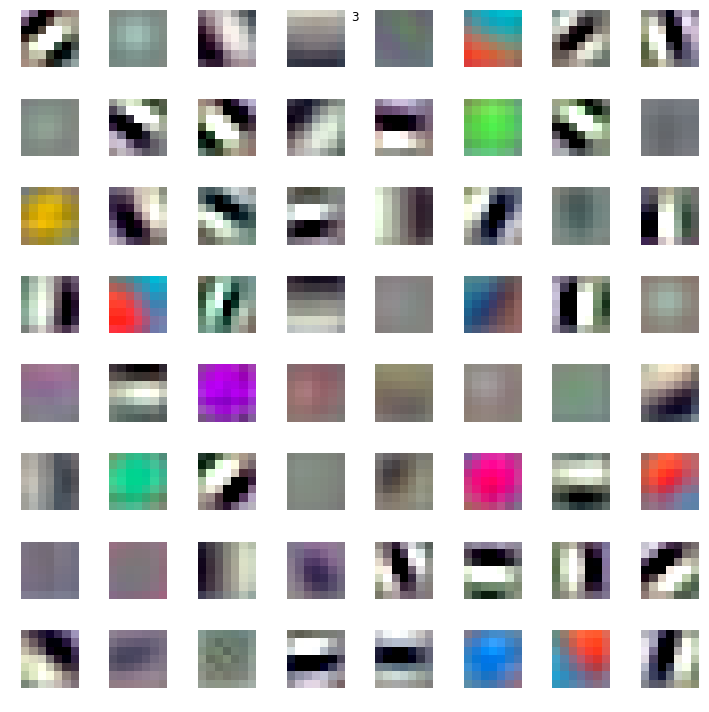

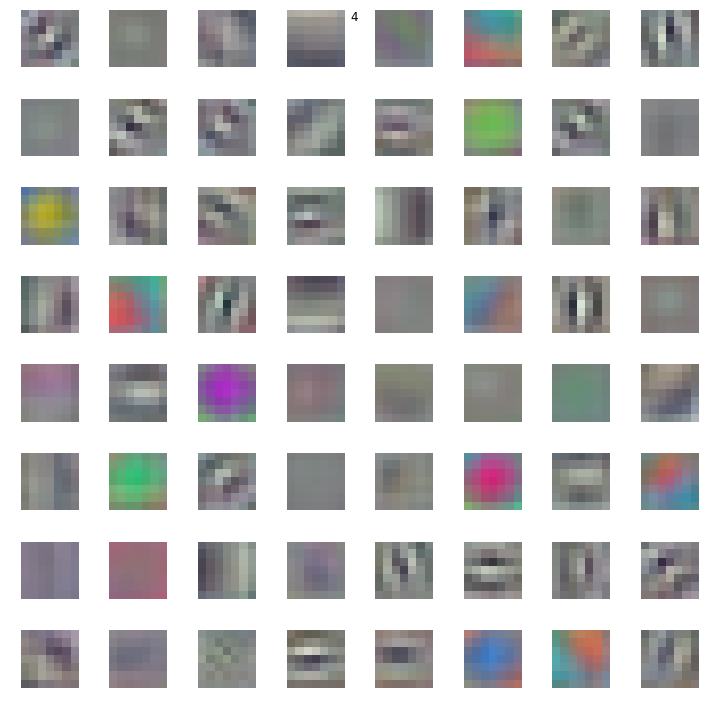

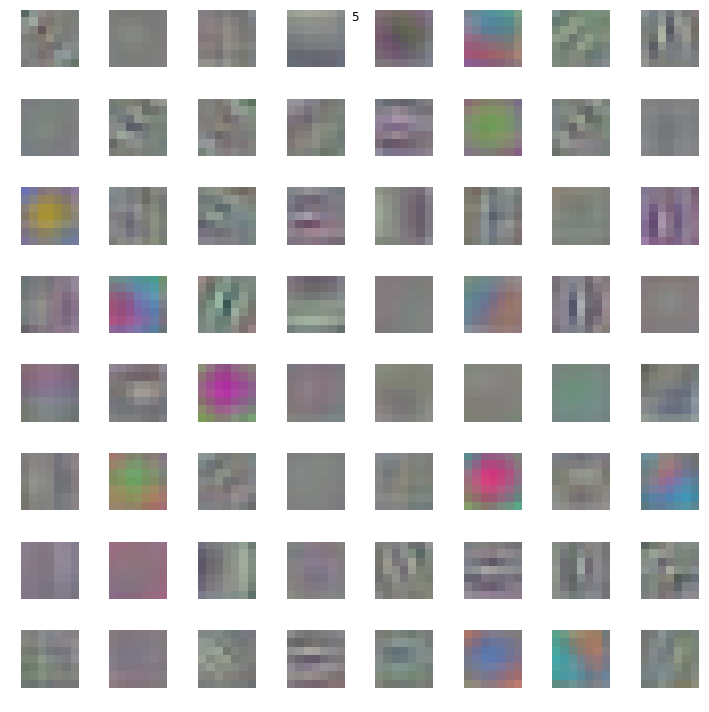

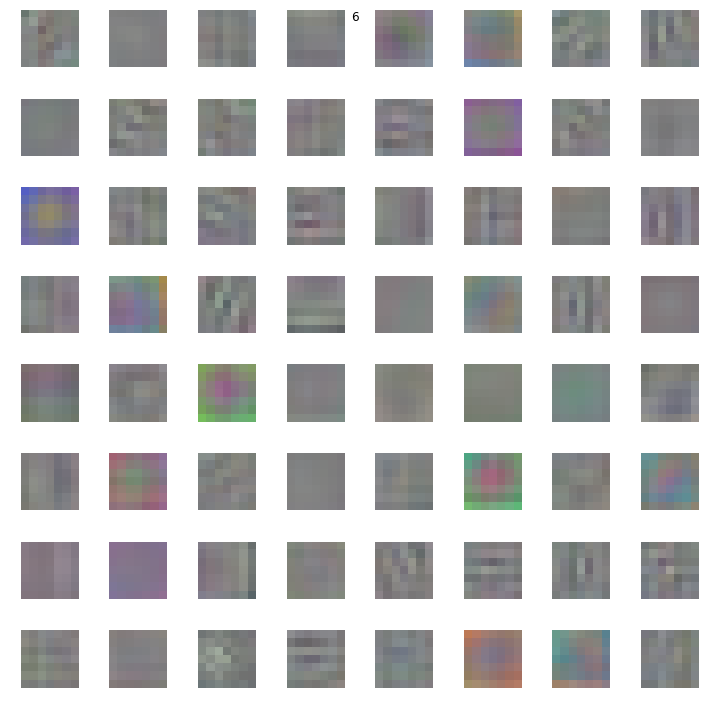

In [10]:
import matplotlib.pyplot as plt
weights = torch.load(weights_rgb[31])['conv3d_1a_7x7.conv3d.weight']
depth = weights.shape[2] # torch.Size([64, 3, 7, 7, 7])

for j in range(depth):
    fig = plt.figure(figsize=(10, 10))
    for i, weight in enumerate(weights):
        num = i+1
        ax = plt.subplot(8, 8, num)
        img = weight[:,j,:,:] # CHW
        if img.shape[0] == 3:
            img = (np.asarray(img.cpu()).transpose(1, 2, 0)+1)/2
        elif img.shape[0] == 2:
            tmp = np.zeros((img.shape[1], img.shape[2], 1))
            img = np.dstack((np.asarray(img.cpu()).transpose(1, 2, 0), tmp))
            img = (img+1)/2
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(j)
    fig.tight_layout()
    fig.savefig("./static/img_activations_{}_rgb.jpg".format(j))
    #plt.show()

In [11]:
import imageio
images = []
for img in sorted(glob('./static/*_rgb.jpg')):
    images.append(plt.imread(img))
imageio.mimsave("./static/first_conv_rgb.gif", images, duration=1)

In [8]:
rgbs, flows, label = dataset['train'].__getitem__(100)

In [16]:
dataset['train'].__getpath__(100)

'/data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames002584_5'

In [9]:
i3d_rgb.load_state_dict(torch.load(weights_rgb[31]))
i3d_flow.load_state_dict(torch.load(weights_flow[97]))

In [9]:
# 1*64*8*112*112
act_rgbs = i3d_rgb.conv3d_1a_7x7(rgbs.unsqueeze(0).to(device))
act_flows = i3d_flow.conv3d_1a_7x7(flows.unsqueeze(0).to(device))

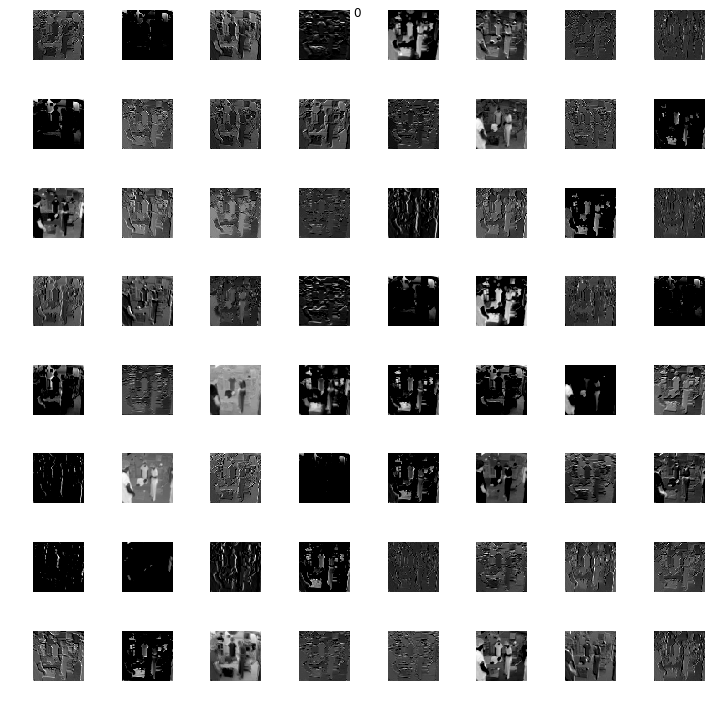

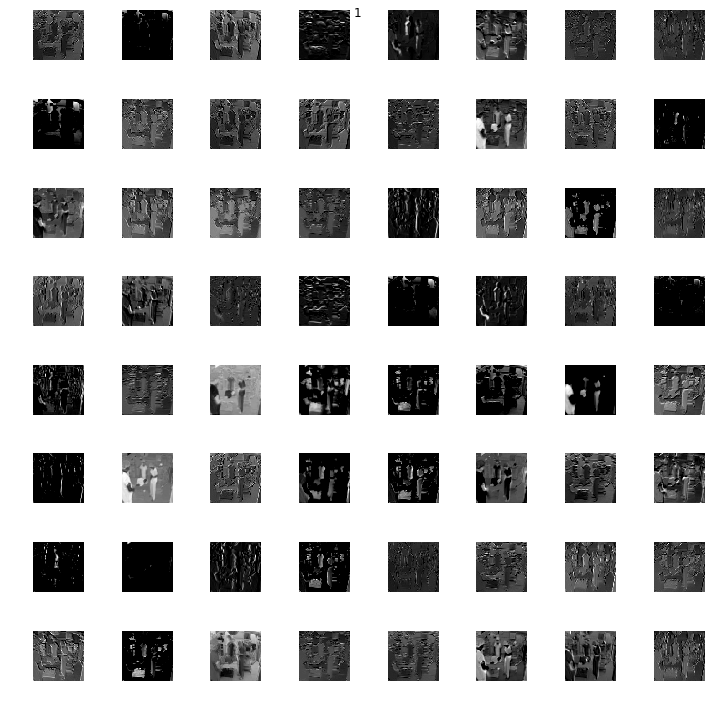

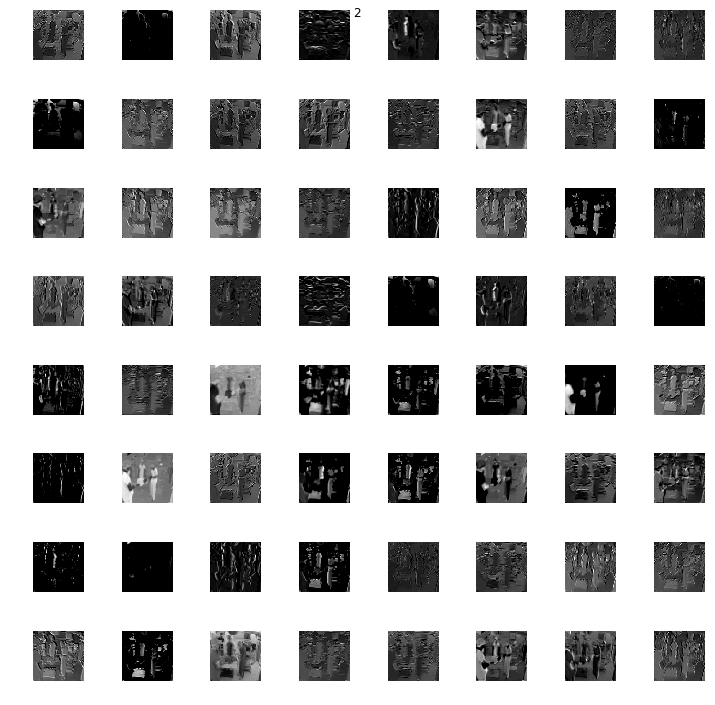

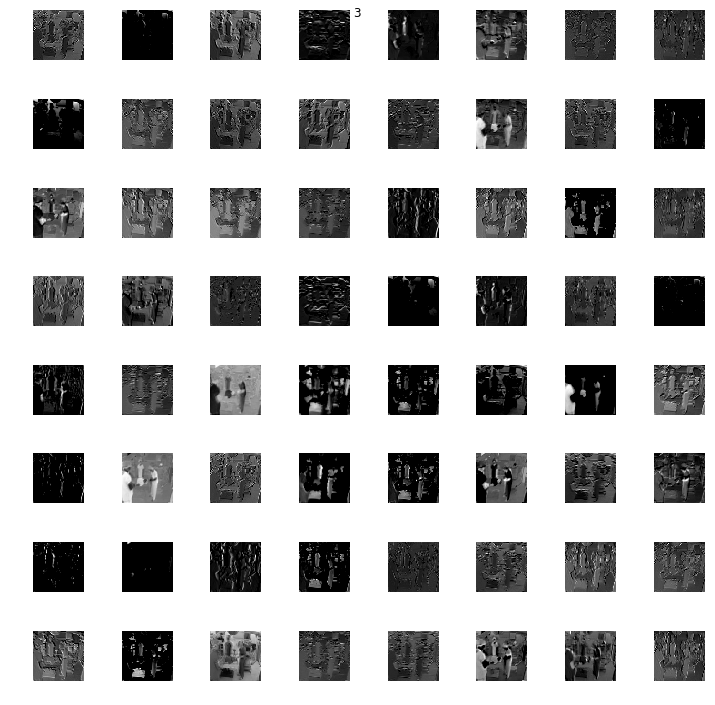

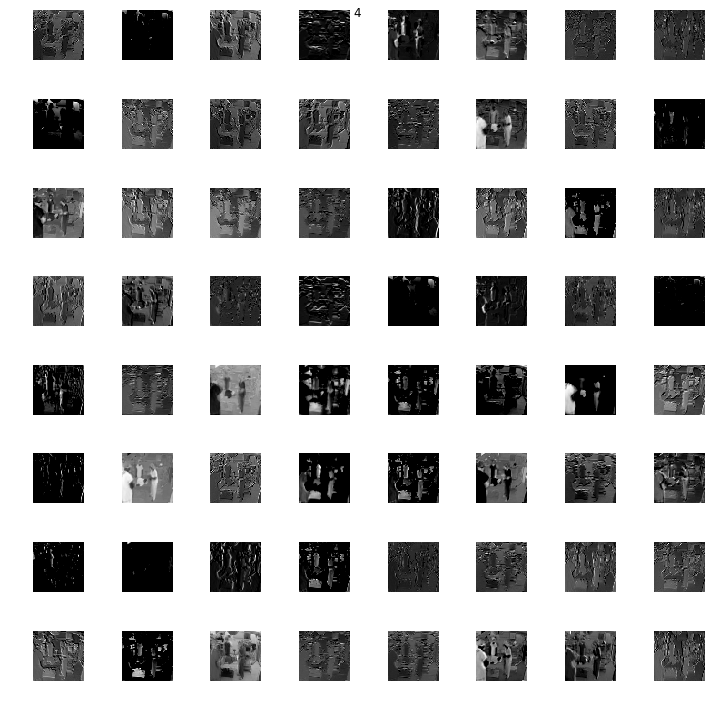

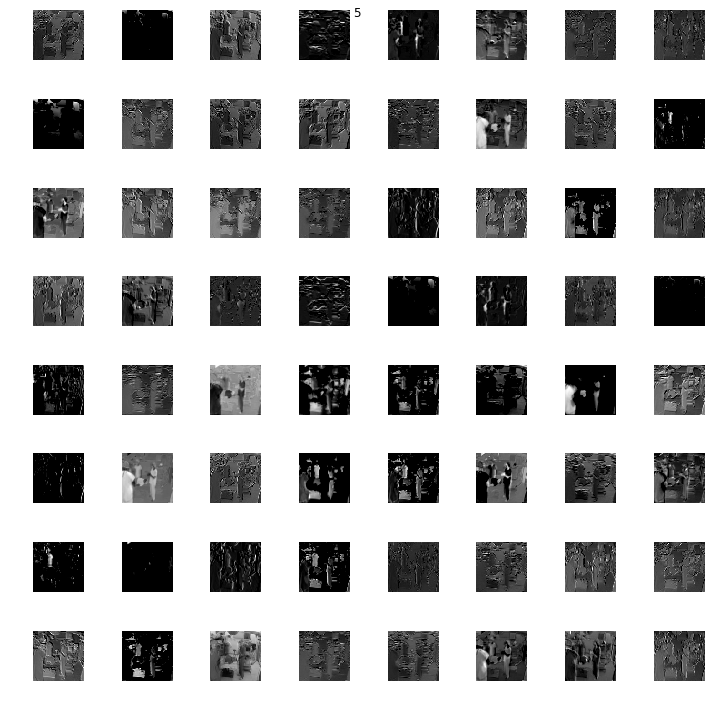

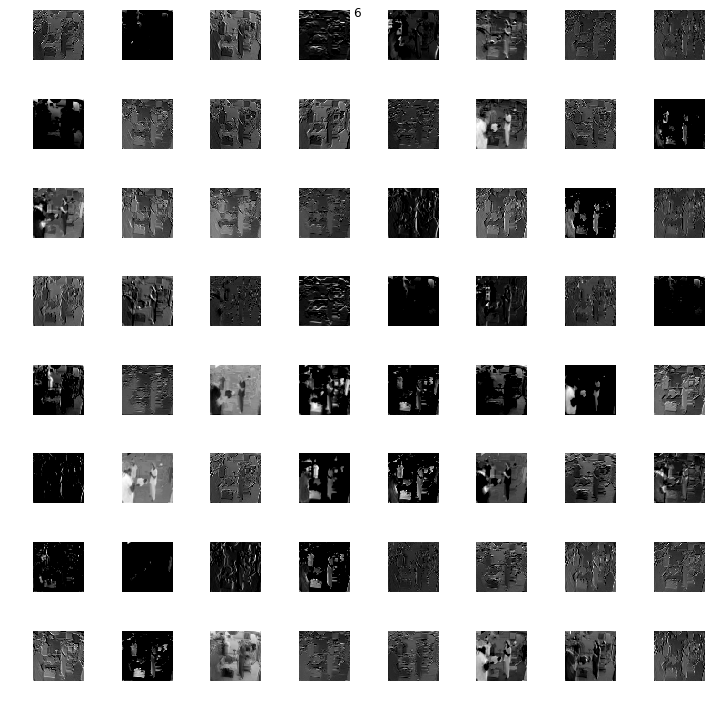

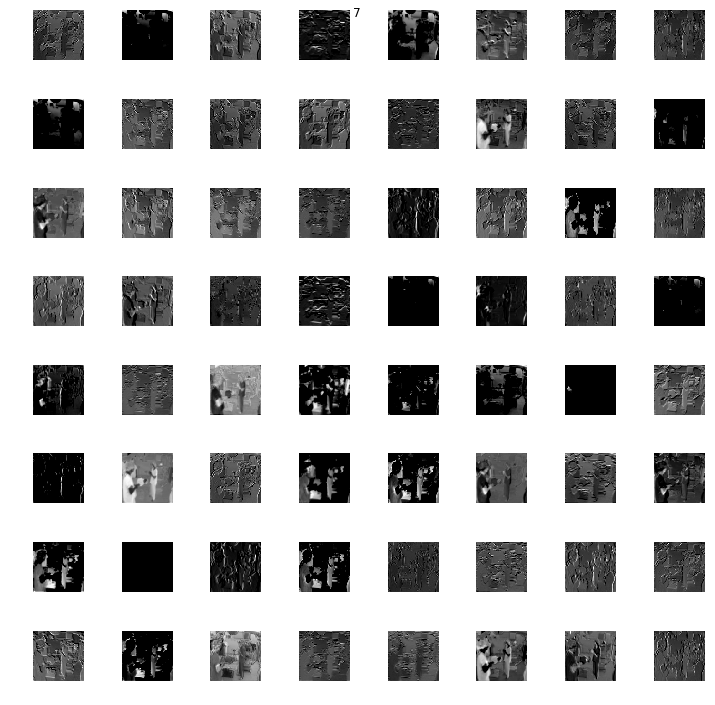

In [14]:
import matplotlib.pyplot as plt
weights = act_rgbs.squeeze(0) # 64 8 112 112
depth = weights.shape[1] #8
for d in range(depth): # 8번
    fig = plt.figure(figsize=(10, 10))
    for i, weight in enumerate(weights):
        # weight: 64x112x112
        num = i+1
        ax = plt.subplot(8, 8, num)
        img = weight[d,:,:] # CHW
        if len(img.shape) == 2:
            img = (img.cpu().detach().numpy()+1)/2
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            continue
        
        if img.shape[0] == 3:
            img = (np.asarray(img.cpu()).transpose(1, 2, 0)+1)/2
        elif img.shape[0] == 2:
            tmp = np.zeros((img.shape[1], img.shape[2], 1))
            img = np.dstack((np.asarray(img.cpu()).transpose(1, 2, 0), tmp))
            img = (img+1)/2
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(d)
    fig.tight_layout()
    fig.savefig("./static/img_initial_activations_{}_rgb.jpg".format(d))
    #plt.show()

In [15]:
from glob import glob
import imageio
images = []
for img in sorted(glob('./static/img_initial_activations_*_rgb.jpg')):
    images.append(plt.imread(img))
imageio.mimsave("./static/first_conv_initial_activations_rgb.gif", images, duration=0.5)

In [ ]:
def get_classmap(conv_outputs, class_weights):
    conv_outputs = conv_outputs[0, :, :, :]
    classmap = np.dot(class_weights.T, conv_outputs.reshape((2048, -1)))
    classmap = classmap.reshape((32, 32))
    classmap = cv2.resize(classmap, (img_rows, img_cols))
    classmap -= np.min(classmap)
    classmap /= np.max(classmap)
    return classmap

def get_classmap_revised(model, img, class_idx):
    from keras.models import Model
    last_conv_model = Model(inputs=model.input, outputs=model.layers[-9].output) # GAP feature
    conv_outputs = last_conv_model.predict(img)
    class_weights = model.layers[int(class_idx)-6].get_weights()[0]
    final_output = get_classmap(conv_outputs, class_weights)
    return final_output